In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from PIL import Image

In [3]:
!kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset
License(s): CC0-1.0
 98% 157M/160M [00:09<00:00, 22.3MB/s]
100% 160M/160M [00:09<00:00, 17.3MB/s]


In [4]:
import zipfile
import os

zip_file = "/content/sugarcane-leaf-disease-dataset.zip"
extract_folder = "extracted_folder"

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of zip file in the specified directory
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [5]:
import os
import glob
import shutil
import random

def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    # crawls inside folders
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

def split_dataset(source_dir, train_dir, test_dir, val_dir, split_ratio=(0.6, 0.2, 0.2)):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Get list of classes
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_source_dir = os.path.join(source_dir, class_name)
        class_train_dir = os.path.join(train_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)

        if not os.path.exists(class_train_dir):
            os.makedirs(class_train_dir)
        if not os.path.exists(class_test_dir):
            os.makedirs(class_test_dir)
        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

        files = os.listdir(class_source_dir)
        random.shuffle(files)

        num_files = len(files)
        num_train = int(num_files * split_ratio[0])
        num_test = int(num_files * split_ratio[1])
        num_val = num_files - num_train - num_test

        train_files = files[:num_train]
        test_files = files[num_train:num_train+num_test]
        val_files = files[num_train+num_test:]

        for file in train_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_train_dir, file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_test_dir, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_val_dir, file)
            shutil.copy(src, dst)

source_dir = "/content/extracted_folder"
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

split_dataset(source_dir, train_dir, test_dir, val_dir)


In [6]:
# Create train, test, and valid directories
train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/val"

In [7]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

In [8]:
from tensorflow.keras.utils import to_categorical

def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)

    # Convert y_true to binary labels
    y_true = to_categorical(test_gen.classes, num_classes=len(classes))

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true.argmax(axis=1), pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()


In [9]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy")
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

In [10]:
def create_df(dataset_dir):
    image_paths, labels = [], []

    for dirpath, _, filenames in os.walk(dataset_dir):
        for filename in filenames:
            image_path = os.path.join(dirpath, filename)
            image_paths.append(image_path)
            label = os.path.basename(dirpath)  # Extract label from directory name
            labels.append(label)

    df = pd.DataFrame({'Image Path': image_paths, 'Label': labels})
    return df

# Create DataFrames for each dataset
train_df = create_df(train_dir)
valid_df = create_df(valid_dir)
test_df = create_df(test_dir)

# Print the number of samples in each dataset
print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(valid_df))
print("Number of test samples:", len(test_df))

Number of training samples: 1511
Number of validation samples: 508
Number of test samples: 502


In [11]:
train_df

,Image Path,Label
0,/content/train/Mosaic/mosaic (250).jpeg,Mosaic
1,/content/train/Mosaic/mosaic (269).jpeg,Mosaic
2,/content/train/Mosaic/mosaic (215).jpeg,Mosaic
3,/content/train/Mosaic/mosaic (437).jpeg,Mosaic
4,/content/train/Mosaic/mosaic (272).jpeg,Mosaic
...,...,...
1506,/content/train/Healthy/healthy (121).jpeg,Healthy
1507,/content/train/Healthy/healthy (220).jpeg,Healthy
1508,/content/train/Healthy/healthy (92).jpeg,Healthy
1509,/content/train/Healthy/healthy (227).jpeg,Healthy


In [12]:
batch_size = 32

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe(train_df, x_col='Image Path', y_col='Label', target_size=(224, 224), class_mode='categorical',
                                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = valid_data_generator.flow_from_dataframe(valid_df, x_col='Image Path', y_col='Label', target_size=(224, 224), class_mode='categorical',
                                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = valid_data_generator.flow_from_dataframe(test_df, x_col='Image Path', y_col='Label', target_size=(224, 224), class_mode='categorical',
                                                   color_mode='rgb', shuffle=False, batch_size=batch_size)

train_steps = train_gen.n // train_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size + 1


Found 1511 validated image filenames belonging to 5 classes.
Found 508 validated image filenames belonging to 5 classes.
Found 502 validated image filenames belonging to 5 classes.


In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Layer, Activation
from tensorflow.keras.optimizers import Adamax

# Define the self-attention layer
class SelfAttention(Layer):
    def __init__(self, units, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        vu = tf.matmul(v, self.u)
        alpha = tf.nn.softmax(vu, axis=1)
        output = inputs * alpha
        return output


# Load the EfficientNetB0 model without the top (fully connected layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model to keep pre-trained weights
base_model.trainable = False

# Add custom top layers for binary classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = SelfAttention(units=1024)(x)  # Adding self-attention layer
x = Dense(512, activation='relu')(x)
x = SelfAttention(units=1024)(x)  # Adding self-attention layer
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)

# Create new model
efficient_net_model = Model(base_model.input, x, name="EfficientNetB0_model")

# Compile the model
efficient_net_model.compile(optimizer=Adamax(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

efficient_net_model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "EfficientNetB0_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.utils import to_categorical

# Define the self-attention layer
class SelfAttention(Layer):
    def __init__(self, units, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        vu = tf.matmul(v, self.u)
        alpha = tf.nn.softmax(vu, axis=1)
        output = inputs * alpha
        return output

# Load the EfficientNetB0 model without the top (fully connected layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model to keep pre-trained weights
base_model.trainable = False

# Add custom top layers for multi-class classification with 5 classes
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = SelfAttention(units=1024)(x)  # Adding self-attention layer1

x = Dense(512, activation='relu')(x)
x = SelfAttention(units=1024)(x)  # Adding self-attention layer2
x = Dense(128, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)  # Adjust to 5 classes for multi-class classification

# Create new model
efficient_net_model = Model(base_model.input, outputs, name="EfficientNetB0_model")

# Compile the model
efficient_net_model.compile(optimizer=Adamax(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Assuming train_gen yields tuples of (samples, labels)
train_samples, train_labels = next(train_gen)

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=5)  # Adjust num_classes to 5 for 5 classes

epochs = 70
# Now train the model with the one-hot encoded labels
history_efficient_net = efficient_net_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    verbose=1
)



Epoch 1/70
48/48 [==============================] - 27s 328ms/step - loss: 0.7901 - accuracy: 0.6830 - val_loss: 0.5359 - val_accuracy: 0.8150
Epoch 2/70
48/48 [==============================] - 14s 297ms/step - loss: 0.4027 - accuracy: 0.8557 - val_loss: 0.3947 - val_accuracy: 0.8602
Epoch 3/70
48/48 [==============================] - 14s 298ms/step - loss: 0.3007 - accuracy: 0.8968 - val_loss: 0.4549 - val_accuracy: 0.8465
Epoch 4/70
48/48 [==============================] - 14s 295ms/step - loss: 0.2160 - accuracy: 0.9259 - val_loss: 0.3290 - val_accuracy: 0.8858
Epoch 5/70
48/48 [==============================] - 14s 299ms/step - loss: 0.1562 - accuracy: 0.9504 - val_loss: 0.2948 - val_accuracy: 0.8898
Epoch 6/70
48/48 [==============================] - 14s 297ms/step - loss: 0.1350 - accuracy: 0.9576 - val_loss: 0.3030 - val_accuracy: 0.8917
Epoch 7/70
48/48 [==============================] - 14s 297ms/step - loss: 0.1004 - accuracy: 0.9709 - val_loss: 0.3871 - val_accuracy: 0.8602

In [15]:
true_labels = []
predicted_classes = []

for i in range(validation_steps):
    samples, labels = next(valid_gen)
    predictions = efficient_net_model.predict(samples)
    true_classes = np.argmax(labels, axis=1)
    batch_predicted_classes = np.argmax(predictions, axis=1)
    true_labels.extend(true_classes)
    predicted_classes.extend(batch_predicted_classes)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

# Remove classes with zero support
non_zero_classes = np.unique(true_labels)
predicted_classes_filtered = [pc for pc, tl in zip(predicted_classes, true_labels) if tl in non_zero_classes]
true_labels_filtered = [tl for tl in true_labels if tl in non_zero_classes]

# Print classification report
print(classification_report(true_labels, predicted_classes, zero_division=1))


1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       105
           1       0.91      0.92      0.91        93
           2       0.96      0.88      0.92       105
           3       0.93      0.94      0.94       104
           4       0.92      0.91      0.92       101

    accuracy                           0.93       508
   macro avg       0.93      0.93      0.93       508
weighted avg       0.93      0.93      0.93       508



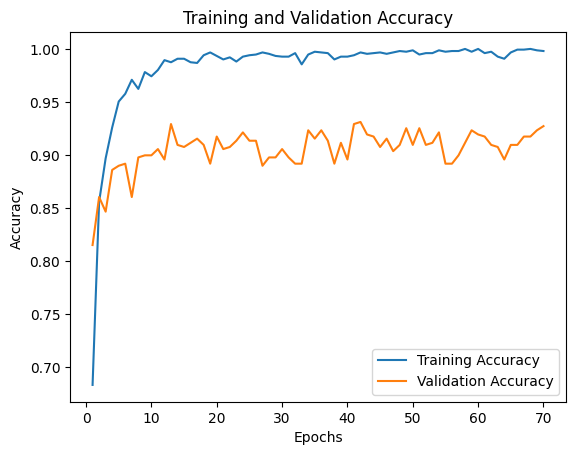

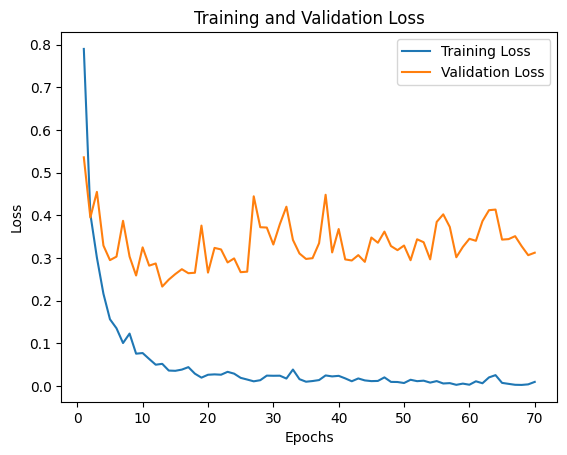

In [16]:

# Obtain training and validation accuracy and loss
training_accuracy = history_efficient_net.history['accuracy']
validation_accuracy = history_efficient_net.history['val_accuracy']
training_loss = history_efficient_net.history['loss']
validation_loss = history_efficient_net.history['val_loss']

# Plotting training and validation accuracy
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
efficient_net_model.save('saved_efficientnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Assuming valid_gen is your validation data generator

# Generate predictions on validation data
predictions = efficient_net_model.predict(valid_gen)

# Convert one-hot encoded labels to integer format
true_labels = np.concatenate([np.argmax(labels, axis=1) for _, labels in valid_gen])

# Convert predicted probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(true_labels, predicted_classes))


16/16 [==============================] - 12s 655ms/step
